<a href="https://colab.research.google.com/github/Aman19960110/Aman19960110.github.io/blob/main/pairs_tading_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import yfinance as yf

In [2]:
symbols = ['360ONE.NS','AUBANK.NS']
data = yf.download(symbols,start='2025-08-01',end='2026-02-13')['Close']
data.dropna(inplace=True)
data_log = np.log(data)

/tmp/ipython-input-3579665157.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols,start='2025-08-01',end='2026-02-13')['Close']
[*********************100%***********************]  2 of 2 completed


In [3]:
def estimate_hedge_ratio(train_y1, train_y2):
    model = OLS(train_y1, add_constant(train_y2)).fit()
    gamma = model.params[1]
    mu = model.params[0]
    return gamma, mu


In [4]:
gamma, mu = estimate_hedge_ratio(data_log[symbols[0]],data_log[symbols[1]])

/tmp/ipython-input-4198343361.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = model.params[1]
/tmp/ipython-input-4198343361.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = model.params[0]


In [5]:
def compute_spread(y1, y2, gamma):
    return y1 - gamma * y2


In [6]:
spread = compute_spread(data_log[symbols[0]],data_log[symbols[1]],gamma)

<Axes: xlabel='Date'>

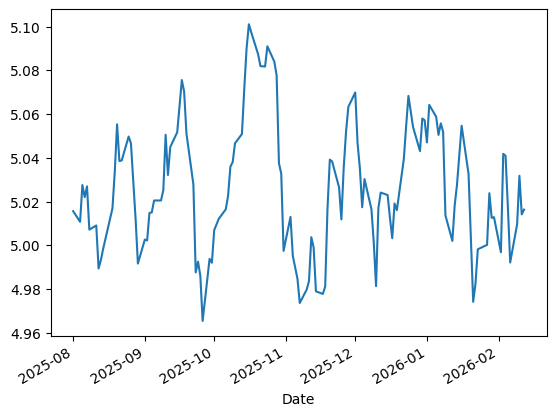

In [7]:
spread.plot()

In [8]:
def compute_zscore(spread, window):
    rolling_mean = spread.rolling(window).mean()
    rolling_std = spread.rolling(window).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore


In [9]:
zscore = compute_zscore(spread,30)

<Axes: xlabel='Date'>

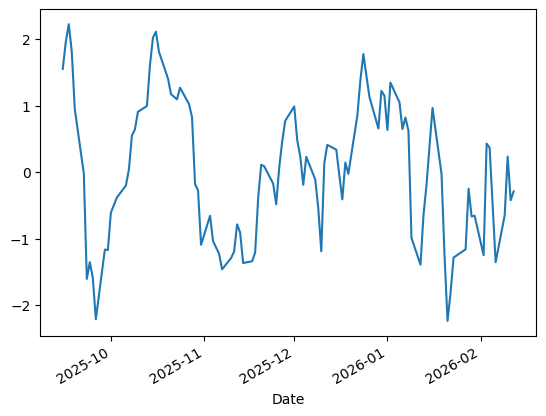

In [10]:
zscore.plot()

In [11]:
def generate_signals(z, entry=2.0, exit=0.5):

    long_entry = z < -entry
    short_entry = z > entry
    exit_signal = abs(z) < exit

    position = np.zeros(len(z))

    for t in range(1, len(z)):
        if position[t-1] == 0:
            if long_entry.iloc[t]:
                position[t] = 1
            elif short_entry.iloc[t]:
                position[t] = -1
        elif position[t-1] == 1:
            if exit_signal.iloc[t]:
                position[t] = 0
            else:
                position[t] = 1
        elif position[t-1] == -1:
            if exit_signal.iloc[t]:
                position[t] = 0
            else:
                position[t] = -1

    return pd.Series(position, index=z.index)


In [12]:
signals = generate_signals(zscore)

In [13]:
def compute_positions(position_signal, price1, price2, gamma, capital=100000):

    qty1 = capital / price1
    qty2 = gamma * qty1

    pos1 = position_signal * qty1
    pos2 = -position_signal * qty2

    return pos1, pos2


In [14]:
pos1,pos2 = compute_positions(signals,data[symbols[0]],data[symbols[1]],gamma,capital=1000000)

In [15]:
pos2

,0
Date,
2025-08-01,-0.0
2025-08-04,-0.0
2025-08-05,-0.0
2025-08-06,-0.0
2025-08-07,-0.0
...,...
2026-02-06,-0.0
2026-02-09,-0.0
2026-02-10,-0.0


In [16]:
def compute_pnl(pos1, pos2, price1, price2, cost_bps=5):

    ret1 = price1.pct_change().fillna(0)
    ret2 = price2.pct_change().fillna(0)

    pnl = pos1.shift(1) * ret1 * price1 + \
          pos2.shift(1) * ret2 * price2

    # Transaction cost
    trades = abs(pos1.diff().fillna(0)) * price1 + \
             abs(pos2.diff().fillna(0)) * price2

    cost = trades * (cost_bps / 10000)

    pnl = pnl - cost

    return pnl.cumsum()


In [ ]:
pnl = compute_pnl(pos1,pos2,signals,data[symbols[0]],data[symbols[1]])

<Axes: xlabel='Date'>

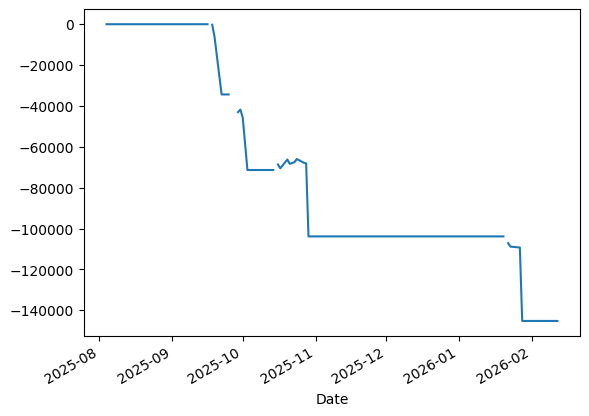

In [ ]:
pnl.plot()

In [17]:
def walkforward_backtest(price1, price2,
                         train_window=100,
                         test_window=30,
                         z_window=30):

    results = []

    for start in range(0, len(price1) - train_window - test_window, test_window):

        train_slice = slice(start, start + train_window)
        test_slice = slice(start + train_window,
                           start + train_window + test_window)

        y1_train = np.log(price1.iloc[train_slice])
        y2_train = np.log(price2.iloc[train_slice])

        gamma, mu = estimate_hedge_ratio(y1_train, y2_train)

        spread = compute_spread(
            np.log(price1),
            np.log(price2),
            gamma
        )

        zscore = compute_zscore(spread, z_window)

        signal = generate_signals(zscore,entry=1.4)

        pos1, pos2 = compute_positions(
            signal,
            price1,
            price2,
            gamma,
            capital= 1000000
        )

        pnl = compute_pnl(
            pos1.iloc[test_slice],
            pos2.iloc[test_slice],
            price1.iloc[test_slice],
            price2.iloc[test_slice]
        )

        results.append(pnl)

    return pd.concat(results)


In [18]:
result = walkforward_backtest(data[symbols[0]],data[symbols[1]])

/tmp/ipython-input-4198343361.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = model.params[1]
/tmp/ipython-input-4198343361.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = model.params[0]


<Axes: xlabel='Date'>

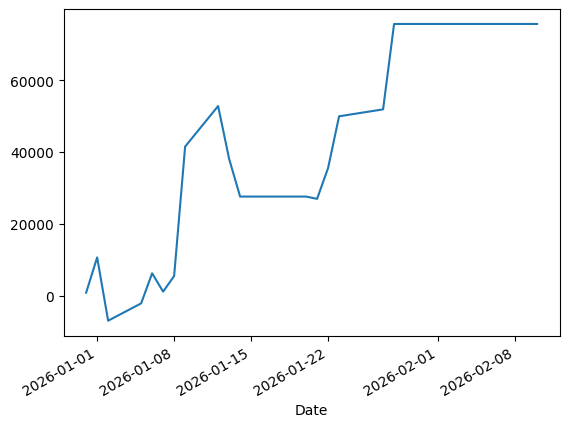

In [19]:
result.diff().dropna().cumsum().plot()

In [20]:
def performance_stats(equity_curve):

    returns = equity_curve.diff().dropna()

    sharpe = np.sqrt(252) * returns.mean() / returns.std()
    max_dd = (equity_curve / equity_curve.cummax() - 1).min()

    return {
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "Total Return": equity_curve.iloc[-1]
    }


In [21]:
performance_stats(result)

{'Sharpe': np.float64(4.108508658743742),
 'Max Drawdown': -0.6974319476187006,
 'Total Return': np.float64(59868.74350741782)}

In [22]:
pd.set_option('display.max_rows',None)
result

,0
Date,
2025-12-29,NaN
2025-12-30,-15763.613005
2025-12-31,-14908.199082
2026-01-01,-5092.536435
2026-01-02,-22707.478460
2026-01-05,-17887.541603
2026-01-06,-9510.708427
2026-01-07,-14619.040145
2026-01-08,-10273.216547


# kalman implementation


In [23]:
import numpy as np
import pandas as pd


In [24]:
def kalman_filter(y1, y2,
                  delta=1e-5,
                  R=0.001):

    n = len(y1)

    # State vector [mu, gamma]
    x = np.zeros((2, n))

    # Covariance matrix
    P = np.eye(2)

    # Process noise
    Q = delta / (1 - delta) * np.eye(2)

    for t in range(1, n):

        # Prediction step
        x_pred = x[:, t-1]
        P_pred = P + Q

        # Observation matrix
        Z = np.array([[1, y2.iloc[t]]])

        # Innovation
        y_pred = Z @ x_pred
        e = y1.iloc[t] - y_pred

        # Innovation variance
        S = Z @ P_pred @ Z.T + R

        # Kalman gain
        K = P_pred @ Z.T @ np.linalg.inv(S)

        # Update step
        x[:, t] = x_pred + (K.flatten() * e)
        P = (np.eye(2) - K @ Z) @ P_pred

    mu = pd.Series(x[0], index=y1.index)
    gamma = pd.Series(x[1], index=y1.index)

    return mu, gamma


In [25]:
def compute_dynamic_spread(y1, y2, gamma):
    return y1 - gamma * y2


In [26]:
def compute_zscore(spread, window=30):
    mean = spread.rolling(window).mean()
    std = spread.rolling(window).std()
    return (spread - mean) / std


In [27]:
def generate_signals(z, entry=2.0):

    position = np.zeros(len(z))

    for t in range(1, len(z)):

        # No position → check entry
        if position[t-1] == 0:
            if z.iloc[t] < -entry:
                position[t] = 1      # long spread
            elif z.iloc[t] > entry:
                position[t] = -1     # short spread

        # Long spread → exit when cross above 0
        elif position[t-1] == 1:
            if z.iloc[t-1] < 0 and z.iloc[t] >= 0:
                position[t] = 0
            else:
                position[t] = 1

        # Short spread → exit when cross below 0
        elif position[t-1] == -1:
            if z.iloc[t-1] > 0 and z.iloc[t] <= 0:
                position[t] = 0
            else:
                position[t] = -1

    return pd.Series(position, index=z.index)


In [28]:
def compute_positions(signal, price1, price2, gamma,
                      capital=100000):

    qty1 = capital / price1
    qty2 = gamma * qty1

    pos1 = signal * qty1
    pos2 = -signal * qty2

    return pos1, pos2


In [29]:
def compute_pnl(pos1, pos2, price1, price2,
                cost_bps=0):

    ret1 = price1.pct_change().fillna(0)
    ret2 = price2.pct_change().fillna(0)

    pnl = pos1.shift(1) * ret1 * price1 + \
          pos2.shift(1) * ret2 * price2

    # Transaction cost
    trades = abs(pos1.diff().fillna(0)) * price1 + \
             abs(pos2.diff().fillna(0)) * price2

    cost = trades * (cost_bps / 10000)

    pnl = pnl - cost

    equity = pnl.cumsum()

    return equity


In [30]:
def kalman_pairs_backtest(price1, price2,
                          z_window=30):

    y1 = np.log(price1)
    y2 = np.log(price2)

    mu, gamma = kalman_filter(y1, y2)

    spread = compute_dynamic_spread(y1, y2, gamma)

    z = compute_zscore(spread, z_window)

    signal = generate_signals(z)

    pos1, pos2 = compute_positions(signal,
                                   price1,
                                   price2,
                                   gamma,
                                   capital=1000000
                                   )

    equity = compute_pnl(pos1,
                         pos2,
                         price1,
                         price2)

    return equity, gamma, spread, z


In [31]:
equity, gamma, spread, z = kalman_pairs_backtest(data[symbols[0]], data[symbols[1]])

total_profit = equity.iloc[-1]

print("Total Profit:", total_profit)


Total Profit: 74743.07516807111


<Axes: xlabel='Date'>

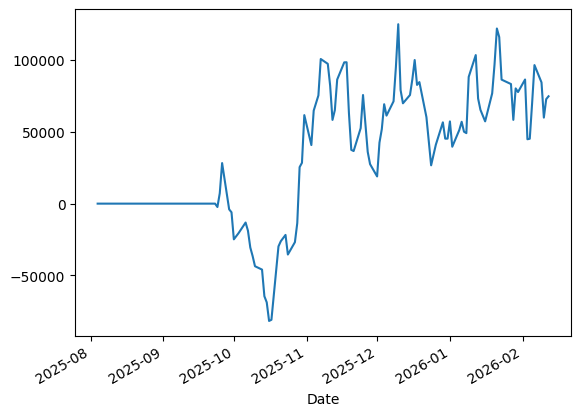

In [35]:
equity.plot()

<Axes: xlabel='Date'>

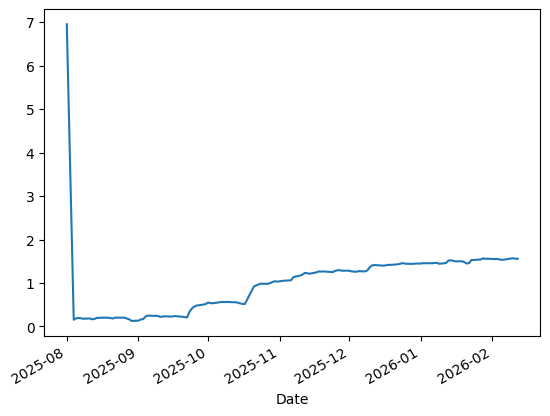

In [36]:
spread.plot()

<Axes: xlabel='Date'>

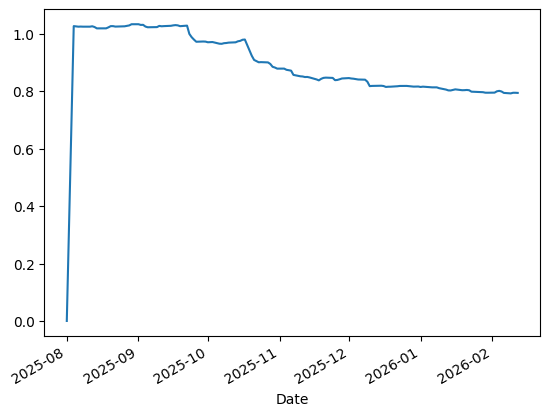

In [37]:
gamma.plot()